<a href="https://colab.research.google.com/github/NateshReddy/Denoising-Algorithm-Implementation/blob/master/cifar10_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A denoising autoencoder for CIFAR10 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10

In [2]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

## Adding noise

In [4]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise_and_clip_data(train_data_clean)
test_data_noisy = add_noise_and_clip_data(test_data_clean)

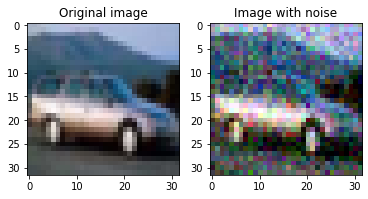

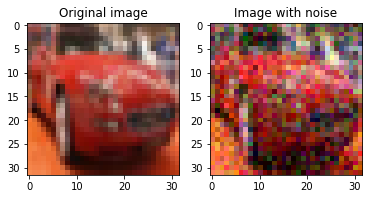

In [5]:
idx = 4
for i in range(2):
  plt.subplot(1,2,1)
  plt.imshow(train_data_clean[idx])
  plt.title('Original image')
  plt.subplot(1,2,2)
  plt.imshow(train_data_noisy[idx])
  plt.title('Image with noise')
  plt.show()
  idx = idx + 1

## Denoising Auto Encoder

In [6]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [7]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)

   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)

   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
  
   return Model(dae_inputs, dae_outputs, name='dae')

## Training


In [ ]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)

dae.fit(train_data_noisy,
       train_data_clean,
       validation_data=(test_data_noisy, test_data_clean),
       epochs=40,
       batch_size=128,
       callbacks=[checkpoint])

Now we load our best model weights and try to predict (denoise) our CIFAR10 test data to visualize how well our DAE performs. 

In [ ]:
dae.save('/content/drive/My Drive/denoising task/model1/model1.h5')
del dae

In [12]:
dae = load_model('/content/drive/My Drive/denoising task/model1/model1.h5')
test_data_denoised = dae.predict(test_data_noisy)

## Visualize original image, noisy image and denoised image

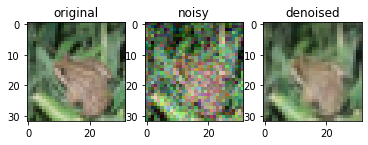

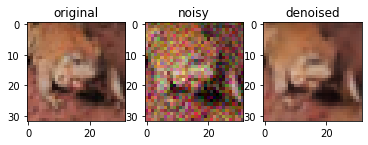

In [13]:
idx = 4
for i in range(2):
  plt.subplot(1,3,1)
  plt.imshow(test_data_clean[idx])
  plt.title('original')
  plt.subplot(1,3,2)
  plt.imshow(test_data_noisy[idx])
  plt.title('noisy')
  plt.subplot(1,3,3)
  plt.imshow(test_data_denoised[idx])
  plt.title('denoised')
  plt.show()
  idx = idx + 1

## Evaluation with the test dataset

We have calculated the PSNR and SSIM of the whole CIFAR10 test set. 

In [14]:
from skimage import metrics
psnr = metrics.peak_signal_noise_ratio(test_data_clean,test_data_denoised)
ssim = metrics.structural_similarity(test_data_clean,test_data_denoised,multichannel=True)
print("PSNR:",psnr,"\nSSIM:",ssim)

PSNR: 27.972259066986148 
SSIM: 0.9834027886157011
